In [2]:
import pandas as pd
from scipy.io import loadmat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

### Capacity (relative to average)

In [3]:
C = 0.1

### Teleportation probability is alpha

In [4]:
alpha = 0.15

### Maximum number of steps is 11

In [5]:
maxSteps = 11

### Load Data from prevous work

In [6]:
Adj = loadmat('Adj.mat')
patient = loadmat('patientNums.mat')

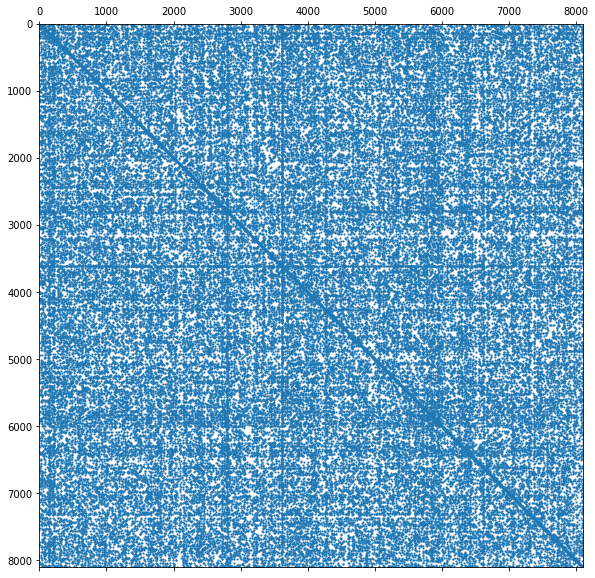

In [7]:
fig = plt.figure(figsize = (10,10))
plt.spy(Adj['Adj'], markersize = 1, precision = 10)

#### Lets work with a 100 doctors for now

In [8]:
docNum = 100

In [9]:
adj  = Adj['Adj'][:docNum,:docNum]
adj = adj.todense()

###  remove self loops

In [10]:
np.fill_diagonal(adj, 0)

#### Load number of patient

In [11]:
mean_patient = patient['MP']

In [12]:
doctors = {}
doctors["originalID"] = np.arange(docNum).squeeze()
print(doctors["originalID"].shape)

(100,)


### Select doctors that are removed

In [13]:
failed = np.random.choice(doctors["originalID"], 2)
print(failed)

[72 58]


In [14]:
lost = 0

In [15]:
doctors["NumOfPatients"] = mean_patient[doctors["originalID"]].astype(int).squeeze() #careful here to put the right ids
doctors["Capacity"] = doctors["NumOfPatients"]*(1+C)

### Doctor Properties

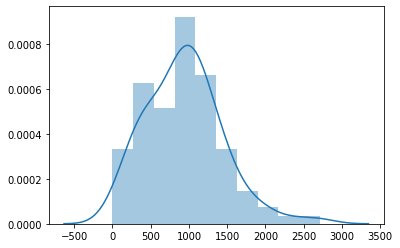

In [16]:
sns.distplot(doctors["NumOfPatients"])

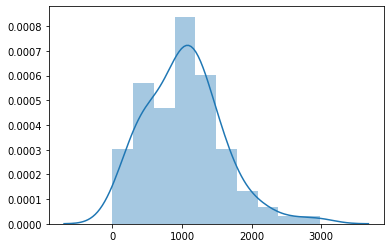

In [17]:
sns.distplot(doctors["Capacity"])

(100,) (100,)


(array([ 9., 17., 14., 25., 18.,  9.,  4.,  2.,  1.,  1.]),
 array([  0. ,  27.1,  54.2,  81.3, 108.4, 135.5, 162.6, 189.7, 216.8,
        243.9, 271. ]),
 <a list of 10 Patch objects>)

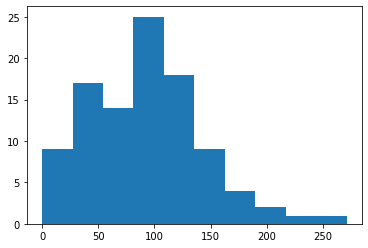

In [18]:
print(doctors["Capacity"].shape, doctors["NumOfPatients"].shape)
plt.hist((doctors["Capacity"]-doctors["NumOfPatients"]).squeeze().astype(int))

In [19]:
G = nx.G=nx.from_numpy_matrix(adj)

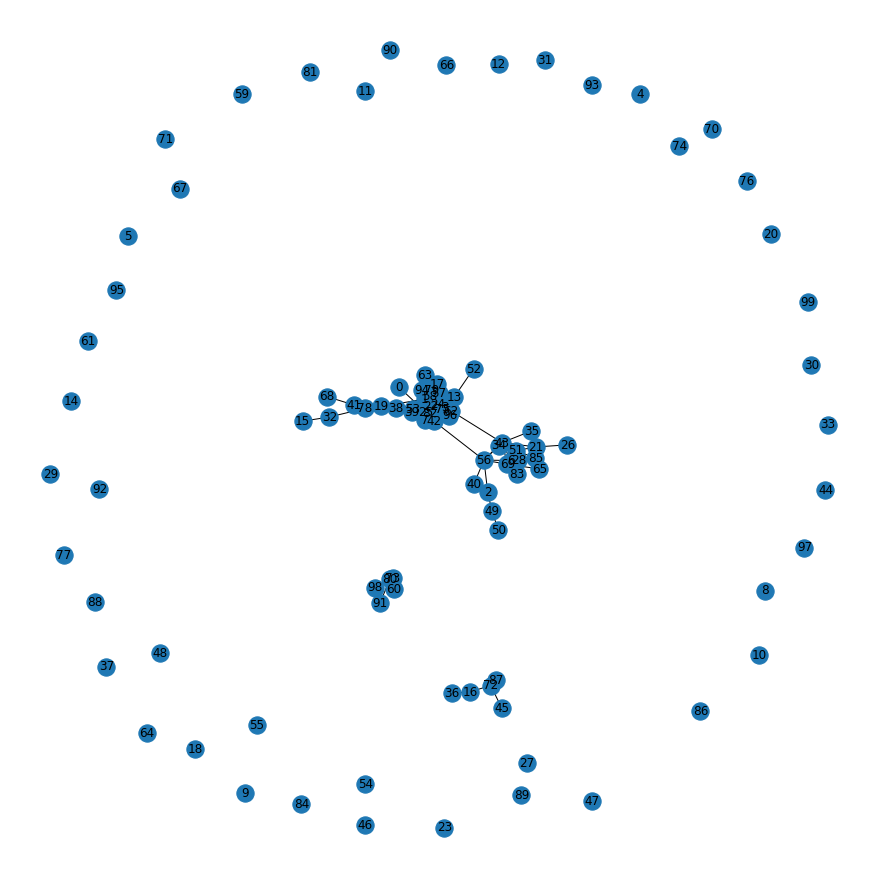

In [20]:
figure = plt.figure(figsize=(12,12))
nx.draw(G, with_labels=True)

In [21]:
totalpatients = doctors["NumOfPatients"][failed].sum()

### Clean out doctors that are disconnected from the network

In [22]:
hasOutDegree = np.any(adj, axis=0).transpose()
hasInDegree = np.any(adj, axis=1)
print(hasInDegree.shape, hasOutDegree.shape)
not_disconnected = np.asarray(np.logical_and(hasOutDegree,hasInDegree)).squeeze()
doctors["originalID"] = doctors["originalID"][not_disconnected.squeeze()]
print(doctors["originalID"])

(100, 1) (100, 1)
[ 1  2  3  6  7 13 16 17 19 21 22 24 25 28 32 34 35 38 39 41 42 43 45 49
 50 51 52 53 56 57 58 60 62 63 65 68 69 72 73 75 78 79 80 82 83 85 87 94
 96 98]


In [23]:
disconnectedFailed = np.logical_not(np.in1d(failed, doctors["originalID"]))

In [24]:
lost+=doctors["NumOfPatients"][failed[disconnectedFailed]].sum()
failed = failed[np.logical_not(disconnectedFailed)]
if failed.size == 0:
    print(lost)

In [25]:
doctors["NumOfPatients"] = doctors["NumOfPatients"][not_disconnected.squeeze()]
doctors["Capacity"] = doctors["Capacity"][not_disconnected.squeeze()]

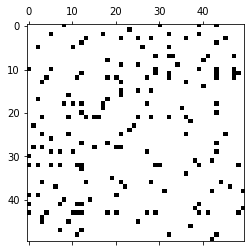

In [26]:
adj = adj[doctors["originalID"], :]
adj = adj[:,doctors["originalID"]]
plt.spy(adj)

### Reindex doctors

In [27]:
doctors["IdForSimulation"] = np.arange(doctors["originalID"].shape[0])
print("original failed: ", failed)
doc2sim = {Id:newID for Id, newID in zip(doctors["originalID"], doctors["IdForSimulation"])}
print(doc2sim)
failed = [doc2sim[f] for f in failed]
print(doctors["IdForSimulation"], failed)

original failed:  [72 58]
{1: 0, 2: 1, 3: 2, 6: 3, 7: 4, 13: 5, 16: 6, 17: 7, 19: 8, 21: 9, 22: 10, 24: 11, 25: 12, 28: 13, 32: 14, 34: 15, 35: 16, 38: 17, 39: 18, 41: 19, 42: 20, 43: 21, 45: 22, 49: 23, 50: 24, 51: 25, 52: 26, 53: 27, 56: 28, 57: 29, 58: 30, 60: 31, 62: 32, 63: 33, 65: 34, 68: 35, 69: 36, 72: 37, 73: 38, 75: 39, 78: 40, 79: 41, 80: 42, 82: 43, 83: 44, 85: 45, 87: 46, 94: 47, 96: 48, 98: 49}
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] [37, 30]


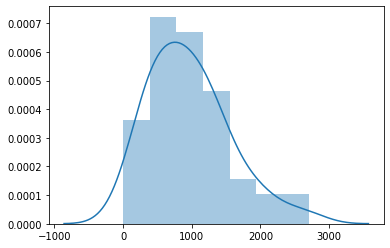

In [28]:
sns.distplot(doctors["NumOfPatients"])

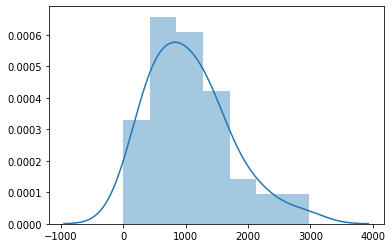

In [29]:
sns.distplot(doctors["Capacity"])

(50,) (50,)


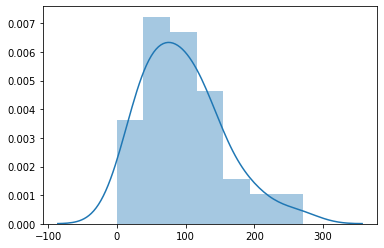

In [30]:
print(doctors["Capacity"].shape, doctors["NumOfPatients"].shape)
sns.distplot((doctors["Capacity"]-doctors["NumOfPatients"]).squeeze().astype(int))

### Randomly select new destination

In [31]:
def vectorized(prob_matrix, items, oldpositions, verbose=False):
    ''''
    Given a probability matrix and a list of items it selects on item based on the column of probability matrix
    '''

    s = prob_matrix.cumsum(axis=0)
    r = np.random.rand(prob_matrix.shape[1])
    k = (s < r).sum(axis=0)
    if verbose:
        print("k-shape: ",k.shape, "prob_matrik-shape: ",prob_matrix.shape, 
              "oldpositions-shape: ",oldpositions.shape, 
              "no_outlinks-IDs: ",np.nonzero(k == prob_matrix.shape[0]))
    k[k == prob_matrix.shape[0]] = oldpositions[np.asarray(k == prob_matrix.shape[0]).squeeze()] #necessary in the case there is no ourlink
    return items[k]

# TimeStep

In [34]:
def step(patient, adj, doctors, lost, alpha = 0.15, maxSteps = 11, verbose = False):

    prob_weights = adj[patient["locations"][ patient["status"].astype(bool)] ] #Create Transport matrix
    #Assign target nodes to patient
    targets = vectorized(prob_weights.transpose(), doctors["IdForSimulation"], 
                         patient["locations"][ patient["status"].astype(bool)] , verbose)
    teleport = np.random.random(targets.shape)<alpha #Choose whether to teleport
    targets[teleport] = np.random.choice(doctors["IdForSimulation"]) #Teleport patient
    patient["locations"][ patient["status"].astype(bool)] = targets.squeeze() #Update locations
    #Count doctors["incoming"] patient
    doctors["incoming"], _ = np.histogram(targets, bins=np.arange(len(doctors["IdForSimulation"])+1))
    for i, doc in enumerate(doctors["IdForSimulation"]):
        at_doc = len(np.asarray(patient["locations"][ patient["status"].astype(bool)] == doc).nonzero()[0])
        print('%%%%%%%%%%',doctors["incoming"][i]-at_doc)
    doctors["availability"] = (doctors["Capacity"]-doctors["NumOfPatients"]).squeeze().astype(int) #Calculate current availability
    doctors["availability"][doctors["availability"]<0] = 0
    if verbose:
        sns.distplot(doctors["availability"])
        plt.show()
    #Compute how many patient will need to continue their search
    doctors["Excess"] = doctors["incoming"]-doctors["availability"] 
    Absorbed = (doctors["Excess"]<=0) #Check whether doctors have absorbed their load
    #Doctors that have absorbed their load need not send out patient (these would be negative numbers)
    doctors["Excess"][Absorbed] = 0 
    #Compute number of patient per doctor
    doctors["NumOfPatients"][Absorbed] =  doctors["NumOfPatients"][Absorbed] + doctors["incoming"][Absorbed]
    #Fill up doctors that have not absorbed the load
    doctors["NumOfPatients"][np.logical_not(Absorbed)] = doctors["Capacity"][np.logical_not(Absorbed)]
    #Patients at doctor that have absorbed can stop
    patient["status"][ np.in1d(patient["locations"], doctors["IdForSimulation"][Absorbed]) ] = 0 
    
    patient["displacements"][ patient["status"].astype(bool) ]+=1 #Update number of displacements
    # Randomply pick patient that can stay at doctors that have filled up
    for doc in doctors["IdForSimulation"]: 
        # Skip doctors with now patient doctors["incoming"]
        if doctors["incoming"][doc] and not Absorbed[doc] and doctors["availability"][doc] != 0:
            #Determine indices of patient at location
            at_doc = np.asarray(patient["locations"][ patient["status"].astype(bool)] == doc).nonzero()[0] 
            #Randomly pick the patient
            if verbose:
                print("at_doc-shape: ", at_doc.shape, "availability: ", doctors["availability"][doc].astype(int))
            kept = np.random.choice(at_doc, size = doctors["availability"][doc], replace = False)
            print(kept.size)
            patient["status"][kept] = 0 #Change status of the lucky ones
    patient["status"][ patient["displacements"]>=maxSteps ] = 0
    lost+= np.array(patient["displacements"]>maxSteps).sum()
    print("Active Patients",patient["status"].sum())
    return patient, doctors, lost

### Patient Status and number of displacements per patient (1 = searching, 0 = found doctor)

In [35]:
patient = {}
patient["locations"] = np.hstack(np.array([i*np.ones(NPats) 
                                    for i, NPats in zip(failed,
                                                        doctors["NumOfPatients"][failed])])).astype(int).squeeze()
patient["status"] = np.ones(patient["locations"].shape, dtype=bool)
patient["displacements"] = np.zeros(patient["locations"].shape)

Active Patients 1064
1
k-shape:  (1, 1064) prob_matrik-shape:  (50, 1064) oldpositions-shape:  (1064,) no_outlinks-IDs:  (array([], dtype=int64), array([], dtype=int64))
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0


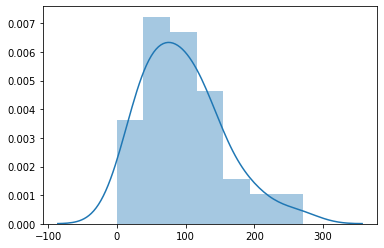

at_doc-shape:  (524,) availability:  95
95
at_doc-shape:  (378,) availability:  8
8
at_doc-shape:  (162,) availability:  114
114
Active Patients 858
2
k-shape:  (1, 858) prob_matrik-shape:  (50, 858) oldpositions-shape:  (858,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0

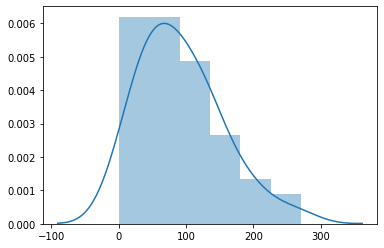

at_doc-shape:  (329,) availability:  83
83
Active Patients 654
3
k-shape:  (1, 654) prob_matrik-shape:  (50, 654) oldpositions-shape:  (654,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0]), array([  0,   1,   2,   

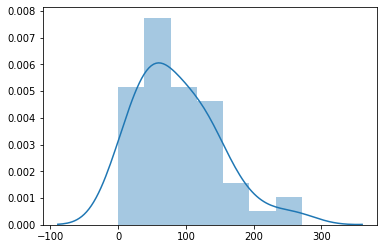

at_doc-shape:  (259,) availability:  237
237
Active Patients 528
4
k-shape:  (1, 528) prob_matrik-shape:  (50, 528) oldpositions-shape:  (528,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), array([  0,   1,   

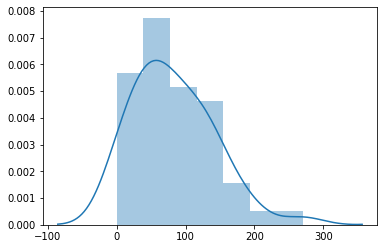

at_doc-shape:  (62,) availability:  51
51
Active Patients 505
5
k-shape:  (1, 505) prob_matrik-shape:  (50, 505) oldpositions-shape:  (505,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), array([  0,   1,   2,   4,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        16,  18,  20,  21,  22,  23,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  3

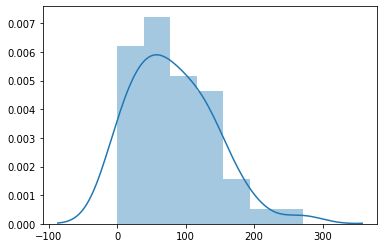

at_doc-shape:  (136,) availability:  73
73
Active Patients 478
6
k-shape:  (1, 478) prob_matrik-shape:  (50, 478) oldpositions-shape:  (478,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([  0,   1,   4,   6,   7,   8,   9,  10,  11,  12,  13,  14,  16,
        19,  20,  21,  22,  26,  27,  28,  29,  31,  32,  33,  34,  35,
        37,  39,  42,  43,  45,  48,  49,  50,  51,  54,  57,  58,  61,
        62,  63,  65,  67,  69,  70,  71,  72,  75,  77,  79,  80,  81,
        82,  83,  84,  85,  87,  88,  89,  9

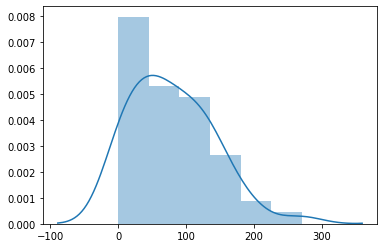

at_doc-shape:  (68,) availability:  42
42
Active Patients 456
7
k-shape:  (1, 456) prob_matrik-shape:  (50, 456) oldpositions-shape:  (456,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0]), array([  0,   1,   3,   5,   6,   8,  10,  12,  15,  16,  21,  22,  23,
        24,  27,  28,  29,  33,  36,  38,  41,  42,  43,  46,  49,  50,
        54,  55,  57,  59,  61,  62,  63,  67,  69,  70,  71,  72,  73,
        74,  75,  77,  78,  79,  81,  82,  86,  88,  89,  92,  93,  94,
        95,  97,  98, 100, 101, 102, 105, 107, 109, 110, 117, 118, 120,
       123, 125, 126, 128, 129, 130, 133, 135, 136, 137, 140, 141, 143,
       

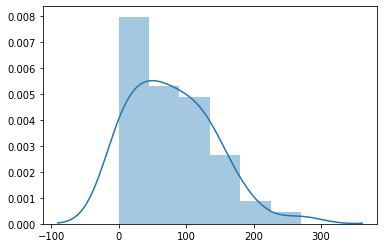

at_doc-shape:  (73,) availability:  39
39
Active Patients 385
8
k-shape:  (1, 385) prob_matrik-shape:  (50, 385) oldpositions-shape:  (385,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0]), array([  2,   5,   6,  10,  13,  14,  18,  19,  20,  21,  23,  24,  27,
        30,  31,  33,  34,  35,  36,  41,  43,  45,  47,  48,  49,  56,
        57,  58,  60,  61,  63,  65,  66,  68,  72,  73,  75,  76,  77,
        79,  80,  83,  85,  93,  96,  98,  99, 101, 103, 106, 107, 108,
       109, 111, 112, 113, 116, 120, 121, 122, 123, 124, 125, 126, 129,
       130, 178, 191, 224, 226, 227, 252, 261, 275, 278, 293, 298, 299,
       320, 321, 333, 338, 348, 349, 356, 369, 373, 375, 383]))
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%

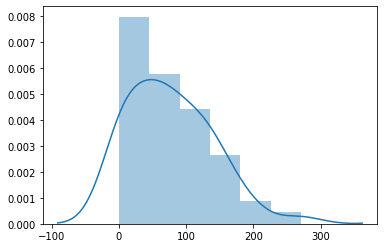

at_doc-shape:  (61,) availability:  35
35
Active Patients 305
9
k-shape:  (1, 305) prob_matrik-shape:  (50, 305) oldpositions-shape:  (305,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([  1,   4,   5,   9,  12,  13,  14,  15,  16,  17,  20,  22,  23,
        24,  27,  30,  32,  39,  40,  42,  46,  47,  49,  50,  52,  54,
        63,  64,  65,  67,  69,  71,  72,  73,  75,  76,  77,  82,  83,
        84,  87,  88, 128, 139, 169, 192, 200, 212, 226, 231, 232, 249,
       250, 259, 263, 272, 273, 278, 290, 294, 296, 304]))
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 

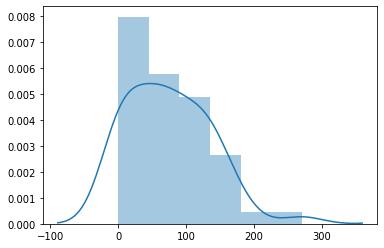

at_doc-shape:  (45,) availability:  25
25
Active Patients 300
10
k-shape:  (1, 300) prob_matrik-shape:  (50, 300) oldpositions-shape:  (300,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0]), array([  3,   4,   8,  10,  11,  12,  13,  14,  15,  16,  18,  20,  21,
        22,  25,  28,  30,  37,  38,  40,  41,  44,  46,  48,  50,  53,
        59,  60,  61,  64,  66,  67,  68,  70,  71,  72,  76,  77,  78,
        79,  82,  83,  90,  97, 100, 105, 109, 118, 123, 132, 133, 134,
       141, 147, 155, 159, 164, 170, 178, 182, 184, 187, 193, 195, 198,
       204, 207, 221, 223, 226, 227, 232, 236, 240, 244, 245, 254, 258,
       267, 268, 269, 270, 273, 274, 285, 289, 291, 296, 299]))
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0


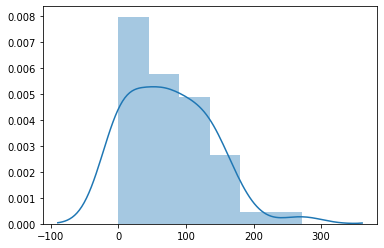

Active Patients 254
11
k-shape:  (1, 254) prob_matrik-shape:  (50, 254) oldpositions-shape:  (254,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([  3,   4,   8,  10,  11,  12,  13,  14,  15,  16,  18,  19,  22,
        25,  27,  33,  34,  35,  36,  39,  41,  43,  49,  50,  51,  54,
        56,  57,  58,  60,  61,  62,  66,  67,  68,  69,  72,  73,  78,
        83,  86,  93, 101, 106, 113, 114, 115, 120, 125, 131, 137, 143,
       153, 155, 158, 164, 166, 168, 173, 189, 191, 192, 196, 199, 202,
       206, 207, 215, 219, 225, 226, 227, 229, 230, 240, 244, 246, 250,
       253]))
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0

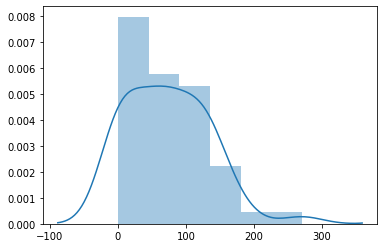

Active Patients 0


In [36]:
adj[:,failed] = 0
t = 1
print("Active Patients",patient["status"].sum())
while np.any(patient["status"]):
    print(t)
    patient, doctors, lost = step(patient, adj, doctors, lost, verbose = True)
    t+=1

In [34]:
patient['status'].sum()/patient['status'].shape[0]

0.0

In [35]:
print(lost)
print(lost/totalpatients)

1521
0.6145454545454545


In [36]:
totalpatients

2475

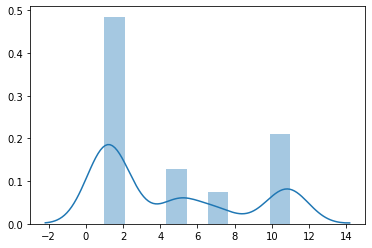

In [37]:
sns.distplot(patient["displacements"])